# Parameter estimation in ESG module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import pickle

Index from SCDAT.A_PRICES (Dimension)

In [2]:
index_df = pd.read_csv('./data/index.csv',index_col='price_date')

In [3]:
index_df.head()

,AK_SV,AK_WORLD,AK_WORLD_LOC,ALTERNATIVA,CPI,FASTIGHETER,KRED_SV,RB_SV_15,RB_SV_1_RATE,RB_SV_5,RB_UTL,SPREAD
price_date,,,,,,,,,,,,
2003-12-31,224.48,4041.233665,591.744572,100.000000,278.0,100.40,196.46,0.048920,0.029400,0.03988,329.8108,0.00379
2004-01-30,238.87,4241.075265,603.376160,100.812146,277.3,100.90,197.80,0.048141,0.027374,0.04050,331.7002,0.00400
2004-02-27,250.56,4341.993088,615.424353,101.725526,279.4,101.40,199.80,0.046236,0.025854,0.03755,335.1980,0.00270
2004-03-31,248.29,4375.960151,610.441767,102.640223,279.4,101.91,202.26,0.046868,0.022710,0.03415,336.7678,0.00290
2004-04-30,251.56,4331.790677,606.675665,101.088818,280.1,102.41,200.78,0.049752,0.024333,0.03875,332.0747,0.00320


In [4]:
stocks = ['AK_SV', 'AK_WORLD', 'AK_WORLD_LOC', 'ALTERNATIVA', 'CPI', 'FASTIGHETER', 'KRED_SV', 'RB_UTL']
rates = ['RB_SV_1_RATE', 'RB_SV_5', 'RB_SV_15', 'SPREAD']

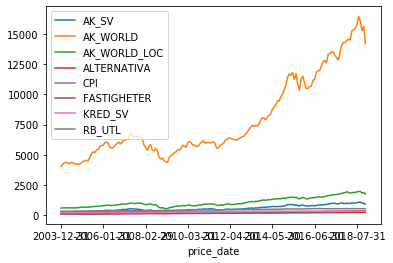

In [5]:
index_df[stocks].plot()

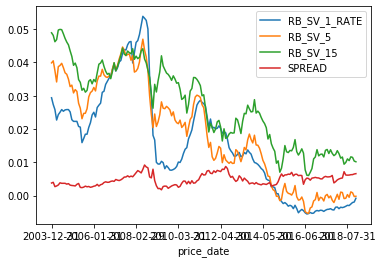

In [6]:
index_df[rates].plot()

In [7]:
returns_df = np.log(index_df[stocks]).diff()[1:]
returns_df[rates] = index_df[rates].diff()[1:]

In [8]:
returns_df.head()

,AK_SV,AK_WORLD,AK_WORLD_LOC,ALTERNATIVA,CPI,FASTIGHETER,KRED_SV,RB_UTL,RB_SV_1_RATE,RB_SV_5,RB_SV_15,SPREAD
price_date,,,,,,,,,,,,
2004-01-30,0.062133,0.048267,0.019466,0.008089,-0.002521,0.004968,0.006798,0.005712,-0.002026,0.00062,-0.000779,0.00021
2004-02-27,0.047779,0.023517,0.019771,0.009019,0.007544,0.004943,0.010060,0.010490,-0.001520,-0.00295,-0.001905,-0.00130
2004-03-31,-0.009101,0.007792,-0.008129,0.008952,0.000000,0.005017,0.012237,0.004672,-0.003144,-0.00340,0.000632,0.00020
2004-04-30,0.013084,-0.010145,-0.006189,-0.015230,0.002502,0.004894,-0.007344,-0.014034,0.001623,0.00460,0.002884,0.00030
2004-05-31,-0.012319,-0.015384,0.001893,-0.001586,-0.004293,0.004870,0.001941,-0.001849,0.000710,0.00035,0.000187,0.00065


### Estimating $\mu$ and $\sigma$ for stocks

In [9]:
variance = returns_df[stocks].var()*12 # 12 months
mean = returns_df[stocks].mean()*12
ar = returns_df[stocks].mean()*0 

### Estimating a, $\mu$ and $\sigma$ for rates

O-U has analytic solution

$r(t) = r_0 e^{-at} + \mu (1 - e^{-at}) + \sigma \int_0^t e^{a(s-t)}dB(s)$

which is discretized

$r_{t+1} = r_t e^{-a\Delta t} + \mu (1 - e^{-a\Delta t}) +
\sigma \sqrt{\frac{1 - e^{-2a\Delta t}}{2a}} \Delta B$

to map coefficients from linear regression

$r_{t+1} = w_1 r_t + w_0 + \epsilon$

In [10]:
reg = linear_model.LinearRegression()

In [11]:
d = 1/12 # months
for rate in index_df[rates]:
    y = index_df[rate][1:].to_numpy()
    X = index_df[rate][:-1].to_numpy().reshape(-1,1)
    reg.fit(X,y)
    w0 = reg.intercept_
    w1 = reg.coef_[0]
    sd = np.sqrt(mean_squared_error(w0 + w1*X, y))
    
    a = -np.log(w1)/d
    mu = w0/(1-w1)
    sigma = sd * np.sqrt(-2*np.log(w1)/(d*(1-w1**2)))
    
    variance[rate] = sigma**2
    mean[rate] = mu
    ar[rate] = a

### Initial values and correlation from observations

In [12]:
s0 = index_df[stocks+rates].iloc[0]
Corr = returns_df.corr()

Simulation parameters

In [13]:
params = (s0, Corr, variance, mean, ar)

In [14]:
with open('./data/params.pkl', 'wb') as f:
    pickle.dump(params, f)